### Credits

https://www.kaggle.com/nikitpatel/random-grid-bayes-search-cv-for-xgb

https://www.kaggle.com/shivamb/extensive-text-data-feature-engineering

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

<h1> 3. Featurizing text data with tfidf weighted word-vectors </h1>

In [2]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Basic EDA on text data

In [3]:
question1 = np.array(df['question1'])
question2 = np.array(df['question2'])

text_df = pd.DataFrame(data=question1, columns=['question1'])

In [4]:
text_df['question2'] = question2

In [80]:
text_df.head()

,question1,question2
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?


In [5]:
text_df['length of q1'] = text_df['question1'].apply(lambda x: len(x.split()))
text_df['length of q2'] = text_df['question2'].apply(lambda x: len(x.split()))

text_df['letter count of q1'] = text_df['question1'].apply(lambda x: len(x))
text_df['letter count of q2'] = text_df['question2'].apply(lambda x: len(x))

In [6]:
text_df.head()

,question1,question2,length of q1,length of q2,letter count of q1,letter count of q2
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,14,12,66,57
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,8,13,51,88
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,14,10,73,59
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,11,9,50,65
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,13,7,76,39


In [7]:
plt_df = text_df.drop(labels=['question1', 'question2'], axis=1)

plt_df['is_duplicate'] = df['is_duplicate']

### plots

In [91]:
plt_df.head()

,length of q1,length of q2,letter count of q1,letter count of q2,is_duplicate
0,14,12,66,57,0
1,8,13,51,88,0
2,14,10,73,59,0
3,11,9,50,65,0
4,13,7,76,39,0


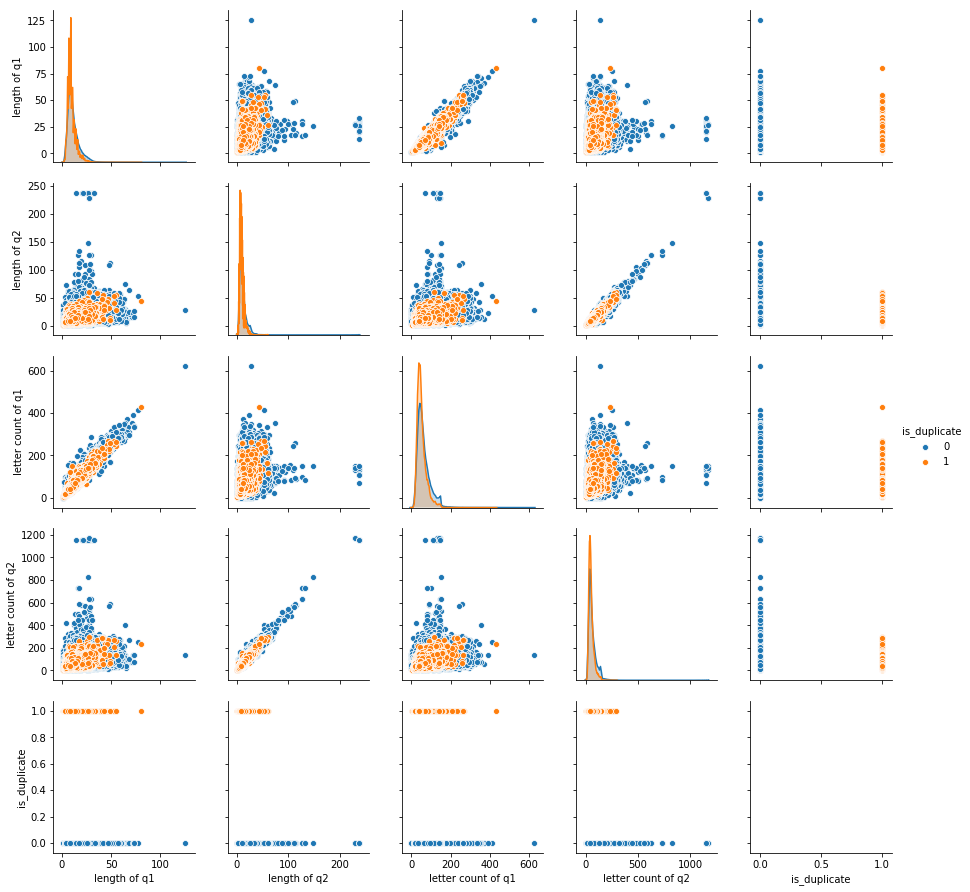

In [92]:
sns.pairplot(data=plt_df, hue='is_duplicate')

#### Not much helpful

In [8]:
plt_df['word_density of q1'] = plt_df['letter count of q1']/ plt_df['length of q1']
plt_df['word_density of q2'] = plt_df['letter count of q2']/ plt_df['length of q2']

In [9]:
plt_df.head()

,length of q1,length of q2,letter count of q1,letter count of q2,is_duplicate,word_density of q1,word_density of q2
0,14,12,66,57,0,4.714286,4.750000
1,8,13,51,88,0,6.375000,6.769231
2,14,10,73,59,0,5.214286,5.900000
3,11,9,50,65,0,4.545455,7.222222
4,13,7,76,39,0,5.846154,5.571429


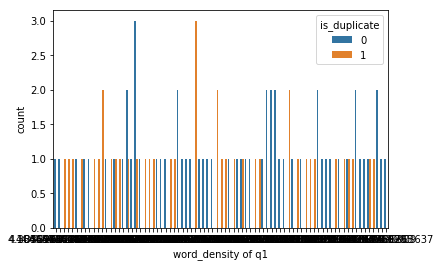

In [11]:
sns.countplot(x='word_density of q1', hue='is_duplicate', data=plt_df.sample(n=100))

#### nothing very helpful here too

In [32]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

In [48]:
freq_q1 = text_df['question1'].apply(lambda x: [wrd for wrd in x.split() if wrd.lower() not in stopwords])
freq_q2 = text_df['question2'].apply(lambda x: [wrd for wrd in x.split() if wrd.lower() not in stopwords])

In [53]:
newfreq1 = []
newfreq2 = []

for i in freq_q1:
    for j in i:
        newfreq1.append(j)

for i in freq_q2:
    for j in i:
        newfreq2.append(j)

In [35]:
from collections import Counter
freq_q1 = [i.split() for i in text_df['question1']]
freq_q2 = [i.split() for i in text_df['question2']]

In [54]:
wc_q1 = WordCloud().generate(str(newfreq1))
wc_q2 = WordCloud().generate(str(newfreq2))

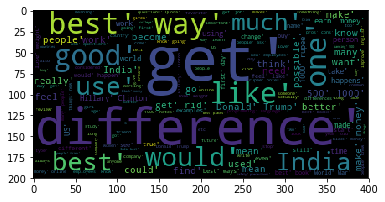

In [55]:
plt.imshow(wc_q1)

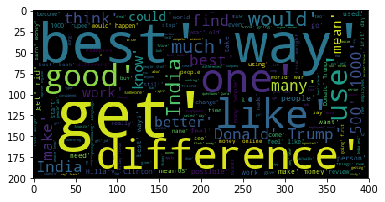

In [56]:
plt.imshow(wc_q2)

### Tfidf vectorization

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#tfidf features for question 1

print(len(df['question1']))
tfidf = TfidfVectorizer(min_df=10, max_features=10000)
tfidf_feats_qn1 = tfidf.fit_transform(df['question1'])

404290


In [5]:
print(len(df['question2']))
tfidf = TfidfVectorizer(min_df=10, max_features=10000)
tfidf_feats_qn2 = tfidf.fit_transform(df['question2'])

404290


### Truncated SVD

In [6]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=1500)
tfidf_feats_qn1 = svd.fit_transform(tfidf_feats_qn1)
tfidf_feats_qn2 = svd.fit_transform(tfidf_feats_qn2)

In [8]:
svd = TruncatedSVD(n_components=500)
tfidf_feats_qn1_500 = svd.fit_transform(tfidf_feats_qn1)
tfidf_feats_qn2_500 = svd.fit_transform(tfidf_feats_qn2)

In [10]:
tfidf_feats_qn1_500.shape

(404290, 500)

In [11]:
df3_q1 = pd.DataFrame(tfidf_feats_qn1_500, columns=[i for i in range(1,501)])

In [12]:
df3_q2 = pd.DataFrame(tfidf_feats_qn2_500, columns=[i for i in range(1,501)])

In [13]:
df3 = pd.concat([df3_q1, df3_q2], axis=1, ignore_index = True)

In [14]:
df3.shape

(404290, 1000)

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [16]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [17]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
# df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
# df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
# df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [9]:
# dataframe of nlp features
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [10]:
# data before preprocessing 
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [18]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
# print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
# print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
# print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12


In [18]:
df1.shape

(404290, 17)

In [19]:
df2.shape

(404290, 12)

In [20]:
df3.shape

(404290, 1000)

In [21]:
# storing the final features to csv file
if not os.path.isfile('final_features_tfidf_vect.csv'):
    df3['id'] = df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    result  = df1.merge(df3, on='id',how='left')
    result.to_csv('final_features_tfidf_vect.csv')

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from file and storing into sql table </h2>

In [2]:
df = pd.read_csv('final_features_tfidf_vect.csv')

In [3]:
df.head()

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,990,991,992,993,994,995,996,997,998,999
0,0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,...,-0.016456,-0.007552,0.000862,0.009068,0.000251,0.012836,-0.010729,0.001022,0.008065,0.011514
1,1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,...,-0.010265,0.001885,-0.002426,0.012678,-0.004546,-0.005041,-0.005618,0.012885,-0.012476,-0.000465
2,2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,...,0.006999,-0.005341,-0.026066,-0.005213,0.020880,-0.003998,-0.001143,0.023749,-0.001854,-0.003089
3,3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.002605,0.002764,-0.003841,0.002326,0.004989,-0.002788,-0.004863,-0.000953,-0.002571,-0.002534
4,4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,...,0.004857,0.003059,0.003909,-0.005973,0.003466,0.007447,-0.000086,0.001682,0.000979,-0.002248


In [4]:
new_df = df.sample(n=100001)

In [5]:
new_df.head()

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,990,991,992,993,994,995,996,997,998,999
266257,266257,266257,0,0.000000,0.000000,0.333322,0.249994,0.199996,0.124998,0.0,...,0.012322,-0.018836,0.000974,0.005047,0.019185,-0.011669,-0.005297,-0.008485,0.009894,0.000452
211099,211099,211099,0,0.749981,0.599988,0.999967,0.499992,0.857131,0.499996,1.0,...,0.009153,-0.020577,-0.004857,0.013464,-0.004287,-0.004151,0.004020,0.014250,0.007144,-0.005830
272693,272693,272693,1,0.999967,0.999967,0.999975,0.799984,0.999986,0.874989,1.0,...,-0.000917,0.011910,-0.002586,0.001586,-0.005333,-0.006704,-0.002408,-0.002981,0.001559,-0.011609
114259,114259,114259,0,0.666644,0.666644,0.749981,0.749981,0.714276,0.714276,0.0,...,0.005634,-0.001633,0.002508,-0.006924,-0.006957,-0.000371,-0.002230,0.008997,0.010113,-0.005050
123479,123479,123479,1,0.499988,0.499988,0.000000,0.000000,0.399992,0.285710,0.0,...,0.012254,0.010949,-0.009574,-0.012802,-0.001948,-0.008070,0.001390,0.005910,0.004199,-0.009341


In [6]:
# remove the first row 
new_df.drop(new_df.index[0], inplace=True)
y_true = new_df['is_duplicate']
new_df.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

In [7]:
new_df.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,990,991,992,993,994,995,996,997,998,999
211099,0.749981,0.599988,0.999967,0.499992,0.857131,0.499996,1.0,1.0,5.0,9.5,...,0.009153,-0.020577,-0.004857,0.013464,-0.004287,-0.004151,0.004020,0.014250,0.007144,-0.005830
272693,0.999967,0.999967,0.999975,0.799984,0.999986,0.874989,1.0,1.0,1.0,7.5,...,-0.000917,0.011910,-0.002586,0.001586,-0.005333,-0.006704,-0.002408,-0.002981,0.001559,-0.011609
114259,0.666644,0.666644,0.749981,0.749981,0.714276,0.714276,0.0,0.0,0.0,7.0,...,0.005634,-0.001633,0.002508,-0.006924,-0.006957,-0.000371,-0.002230,0.008997,0.010113,-0.005050
123479,0.499988,0.499988,0.000000,0.000000,0.399992,0.285710,0.0,0.0,2.0,6.0,...,0.012254,0.010949,-0.009574,-0.012802,-0.001948,-0.008070,0.001390,0.005910,0.004199,-0.009341
390570,0.749981,0.599988,0.999975,0.999975,0.874989,0.777769,1.0,1.0,1.0,8.5,...,-0.032175,0.009952,-0.018100,0.039852,-0.035744,0.028311,0.004621,0.017924,-0.038938,0.006082


<h2> 4.2 Converting strings to numerics </h2>

In [61]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(new_df.columns)
for i in cols:
    new_df[i] = new_df[i].apply(pd.to_numeric)

In [29]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_true = list(map(int, y_true))

<h2> 4.3 Random train test split( 70:30) </h2>

In [17]:
X_train,X_test, y_train, y_test = train_test_split(new_df, y_true, stratify=y_true, test_size=0.3)

In [18]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (70000, 1026)
Number of data points in test data : (30000, 1026)


In [19]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6294571428571428 Class 1:  0.3705428571428571
---------- Distribution of output variable in train data ----------
Class 0:  0.37056666666666666 Class 1:  0.37056666666666666


In [20]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8843979946791319


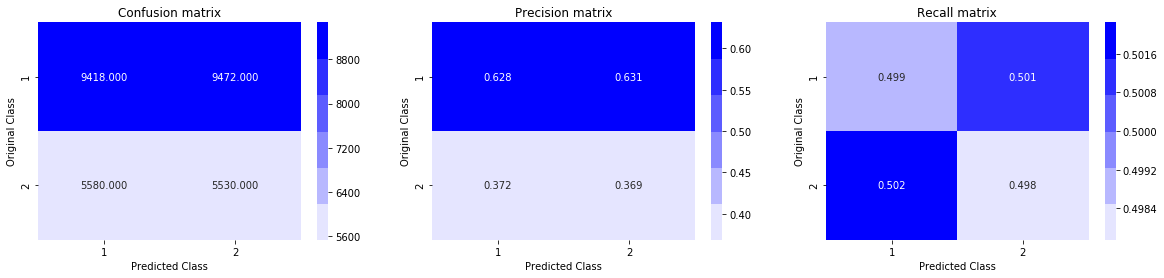

In [23]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4507627454791567
For values of alpha =  0.0001 The log loss is: 0.448322337713395
For values of alpha =  0.001 The log loss is: 0.4462616896695755
For values of alpha =  0.01 The log loss is: 0.44564348820446975
For values of alpha =  0.1 The log loss is: 0.45391994527823626
For values of alpha =  1 The log loss is: 0.48836298304055475
For values of alpha =  10 The log loss is: 0.548748540820288


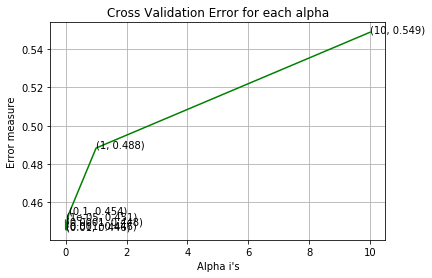

For values of best alpha =  0.01 The train log loss is: 0.4444678904614624
For values of best alpha =  0.01 The test log loss is: 0.44564348820446975
Total number of data points : 30000


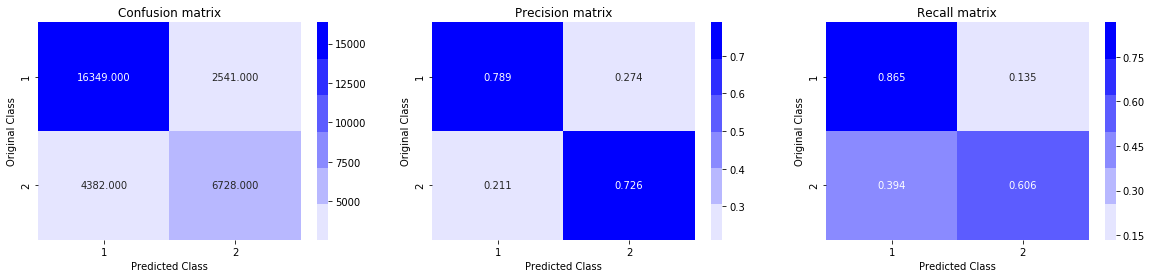

In [24]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.46644021727398627
For values of alpha =  0.0001 The log loss is: 0.4834881586787588
For values of alpha =  0.001 The log loss is: 0.49514738063507413
For values of alpha =  0.01 The log loss is: 0.5128365210591702
For values of alpha =  0.1 The log loss is: 0.5182166754213466
For values of alpha =  1 The log loss is: 0.5956131554576365
For values of alpha =  10 The log loss is: 0.6303364416595282


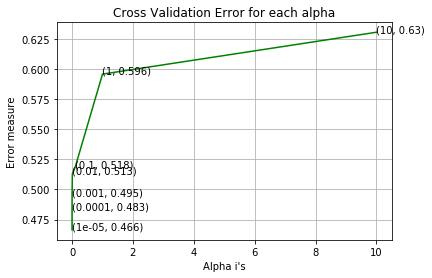

For values of best alpha =  1e-05 The train log loss is: 0.46636629479977937
For values of best alpha =  1e-05 The test log loss is: 0.46644021727398627
Total number of data points : 30000


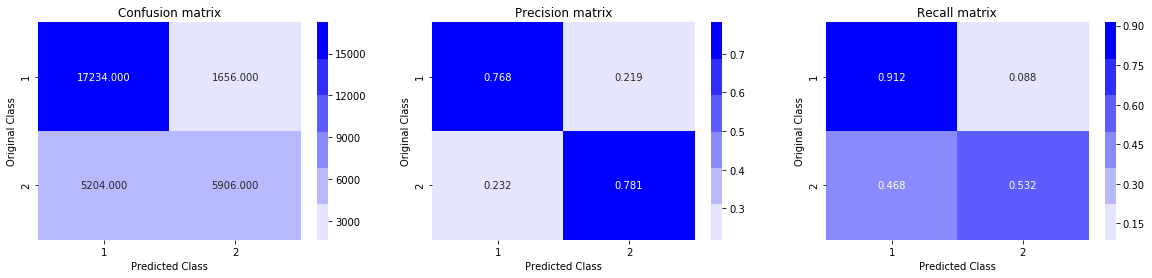

In [25]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

### Hyperparameter tuning

In [35]:
from xgboost import XGBClassifier
from datetime import datetime
start = datetime.now()
clf = XGBClassifier(n_jobs=4, random_state=42, objective='binary:logistic')

# 'tree_method': ['gpu_hist'] add in params for gpu training
params={'colsample_bylevel':[0.4, 0.6, 0.8],
        'subsample':[0.4,0.6,0.8],
        'learning_rate':[0.1,0.2,0.3],
        'n_estimators':[int(x) for x in np.linspace(start=100, stop=500, num=100)],
        'max_depth':[6,8,12,16],
        'gamma':[0.1,0.2,0.3]}

oldparams = {}
oldparams['eval_metric'] = 'logloss'


model = RandomizedSearchCV(estimator=clf, param_distributions=params, n_iter=5, 
                           n_jobs=4,verbose=1, fit_params=oldparams, cv=3, scoring='neg_log_loss', refit=False)

X_train = np.asmatrix(X_train)


model.fit(X_train, y_train)
print('-'*50)
print('end time', datetime.now() - start)

/home/karthikmgcp/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


--------------------------------------------------
end time 1:42:29.794605


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed: 102.5min finished


In [38]:
model.best_params_

{'colsample_bylevel': 0.4,
 'gamma': 0.3,
 'learning_rate': 0.1,
 'max_depth': 6,
 'n_estimators': 334,
 'subsample': 0.6}

In [41]:
model.best_score_

-0.33472719430544884

### applying learned values

In [44]:
clf = XGBClassifier(colsample_bylevel=0.4, gamma=0.3, learning_rate=0.1 
                    ,max_depth=6, n_estimators=334, subsample=0.6, n_jobs=4, random_state=42, objective='binary:logistic')

log_error_array=[]
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)
predict_y = sig_clf.predict_proba(X_test)
log_error_array.append(log_loss(y_test, predict_y, eps=1e-15))
print("The log loss is:",log_loss(y_test, predict_y, eps=1e-15))

The log loss is: 0.341961591632496


In [52]:
predict_y

array([[0.08857286, 0.91142714],
       [0.18282257, 0.81717743],
       [0.88443124, 0.11556876],
       ...,
       [0.95223309, 0.04776691],
       [0.10759632, 0.89240368],
       [0.2350357 , 0.7649643 ]])

In [53]:
y_test[:10]

[1, 0, 0, 1, 1, 1, 0, 0, 0, 0]

In [57]:
real_predict_y = np.argmax(predict_y, axis=1)

In [59]:
real_predict_y[:10]

array([1, 1, 0, 1, 0, 1, 1, 0, 0, 0])

Total number of data points : 30000


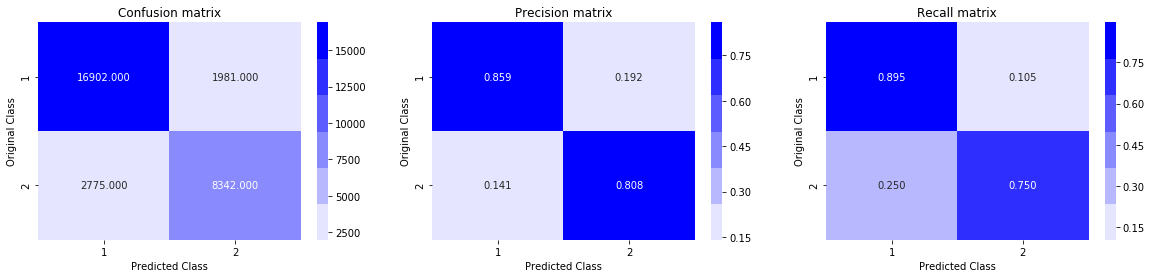

In [60]:
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, real_predict_y)

### Conclusion

### How did I solve?

In [57]:
from prettytable import PrettyTable

In [58]:
x = PrettyTable()

In [59]:
x.field_names = ['algorithm', 'logloss']

In [72]:
x.add_row(['random', '0.88'])

In [78]:
x.sortby = "logloss"
x.reversesort = True

In [79]:
print(x)

+----------------------+---------+
|      algorithm       | logloss |
+----------------------+---------+
|        random        |   0.88  |
|      linear svm      |   0.46  |
| logisitic regression |   0.44  |
|       xgboost        |   0.34  |
+----------------------+---------+
